In [1]:
import os
import pandas as pd
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import seaborn as sns
from dlab.sglx_analysis import readMeta
from dlab import sorting_quality as sq
from matplotlib.gridspec import GridSpec

In [2]:
path = 'Z:\\color_representation\\C51\\20210607_c51_ABC_g1\\'
units_file = glob(path+'*ntermediates\*spiketimes.json')[0]
gratings_file = glob(path+'*ntermediates\*gratings.json')[0]
matrix_file = glob(path+'*ntermediates\*matrices.pkl')[0]

units_df = pd.read_json(open(units_file,'rb'))
matrix_data = pkl.load(open(matrix_file,'rb'))
gratings_data = pd.read_json(open(gratings_file,'rb'))

In [3]:
gratings_data.head()

index    condition  frame_no  TF    SF  ori  green  uv      times
0      0  orientation         9   2  0.16   45    NaN NaN  776.91641
1      1  orientation        14   2  0.16  270    NaN NaN  779.91650
2      2  orientation         8   2  0.16    0    NaN NaN  782.91634
3      3  orientation         6   2  0.08  270    NaN NaN  785.91401
4      4  orientation        10   2  0.16   90    NaN NaN  788.91584

In [6]:
imec0_units = units_df.loc[units_df['probe']=='imec0']
imec0_units.reset_index(inplace = True, drop = True)

imec1_units = units_df.loc[units_df['probe']=='imec1']
imec1_units.reset_index(inplace = True, drop = True)

In [5]:
imec1_units.head()

probe  unit id  depth   amp  no_spikes  \
0  imec1        7    360  47.4          4   
1  imec1       11    460  21.7          4   
2  imec1       13    440  17.4          4   
3  imec1       15    480  73.0          4   
4  imec1       19    520  49.2          4   

                                               times  
0  [3.3904689444000002, 14.290235772900001, 15.30...  
1  [2.6368425141, 3.287636553, 3.3427693814, 3.34...  
2  [0.0994324226, 1.9428155378, 2.4183111824, 2.6...  
3  [79.6596703442, 82.6771760382, 99.4296892575, ...  
4  [0.3064305265, 0.3685966238, 0.4977954404, 0.5...

**Choose a neuron for visualization**

In [6]:
chosen = 30

### Waveform

In [7]:
probe_folder = glob(path+'\*imec0*')[0] #Change the probe number as necessary
bin_file = glob(probe_folder+'\*ap.bin')[0] #Change the probe number as necessary
imec_meta = readMeta(probe_folder+'\\')
sampRate = float(imec_meta['imSampRate']) #get sampling rate (Hz)

In [8]:
mean_wf = sq.mean_waveform(rawdata=bin_file,times=units_df.times[chosen],channels=385,sampling_rate = float(sampRate))

In [184]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

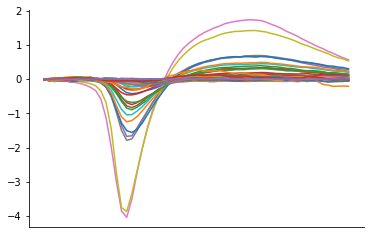

In [188]:
for i in mean_wf:
    plt.plot(i)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xticks([])

### Luminance Receptive Field

Generates maximal receptive field for the highspeed luminance matrix. All RFs at different tau values are contained in `output`

In [10]:
matrix_lum_data = matrix_data['luminance_data']
matrix_lum_times = matrix_data['luminance_times']

In [22]:
def rf_array(spike_data, unit, stim_data, stim_times,num_taus=8):
    spiketimes = np.array(spike_data['times'][unit])
    taus = np.round(np.linspace(-0.01,0.28,num_taus),2)
    srf_list=[]
    
    for k,tau in tqdm(enumerate(taus)):
        idx_arr = []
        stimspikes = []
        spiketime_adj = spiketimes-tau
        for i in range(spiketimes.shape[0]):
            bool_idx = np.logical_and(spiketime_adj[i] > datatimes[0] , spiketime_adj[i] < datatimes[-1])
            idx_arr.append(bool_idx)
        spike_adj_stim = spiketime_adj[idx_arr]

        frame_index = []
        for j in range(spike_adj_stim.shape[0]):
            stim_frame = np.min(np.where(datatimes>spike_adj_stim[j]))-1
            frame_index.append(stim_frame)    

        srf_frames = data[frame_index]
        srf = srf_frames.mean(axis=(0))
        srf_list.append(srf)

    output = dict(zip(taus,srf_list))
    return(output)

In [23]:
taus = np.round(np.arange(-0.01,0.28,0.03),2)
spiketimes = np.array(imec0_units['times'][chosen])
data = matrix_lum_data
datatimes = matrix_lum_times
srf_list = []

for k,tau in tqdm(enumerate(taus)):
    idx_arr = []
    stimspikes = []
    spiketime_adj = spiketimes-tau
    for i in range(spiketimes.shape[0]):
        bool_idx = np.logical_and(spiketime_adj[i] > datatimes[0] , spiketime_adj[i] < datatimes[-1])
        idx_arr.append(bool_idx)
    spike_adj_stim = spiketime_adj[idx_arr]

    frame_index = []
    for j in range(spike_adj_stim.shape[0]):
        stim_frame = np.min(np.where(datatimes>spike_adj_stim[j]))-1
        frame_index.append(stim_frame)    

    srf_frames = data[frame_index]
    srf = srf_frames.mean(axis=(0))
    srf_list.append(srf)
    
output = dict(zip(taus,srf_list))

maxima = []
for i in output:
    maxima.append(np.max(output[i]))
    
max_idx = np.where(maxima==np.amax(maxima))[0][0]

plt.imshow(tuple(output.items())[max_idx][1])

NameError: name 'chosen' is not defined

In [24]:
def rf_grid(data, colormap ='viridis',interp='none',nrows=5,ncols=2):
    fig,axs = plt.subplots(ncols, nrows,figsize=(10,10))
    axs = axs.ravel()
    for i,j in tqdm(enumerate(taus)):
        data2 = data[j]
        out_mean = np.mean(data2)
        out_std = np.std(data2)
        col_min = out_mean-(out_std*3)
        col_max = out_mean+(out_std*3)
        #Generate subplots
        axs[i].imshow(data2, clim=(col_min,col_max),cmap=colormap, 
                      interpolation=interp
                     )
        for ax in fig.get_axes():
            ax.set_frame_on(False);
            ax.set_xticklabels('',visible=False);
            ax.set_xticks([]);
            ax.set_yticklabels('',visible=False);
            ax.set_yticks([])
            ax.set_aspect(1.0)
            ax.set_xlim(0,64)
            ax.set_ylim(0,64)
        plt.tight_layout()
        return(fig)

10it [00:00, 48.62it/s]


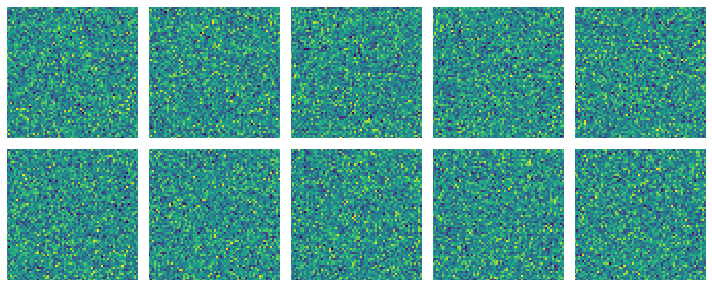

In [14]:
data = output
colormap = 'viridis'
interp = 'none'
nrows = 5
ncols = 2

fig,axs = plt.subplots(ncols, nrows,figsize=(10,10))
axs = axs.ravel()
for i,j in tqdm(enumerate(taus)):
    data2 = data[j]
    out_mean = np.mean(data2)
    out_std = np.std(data2)
    col_min = out_mean-(out_std*3)
    col_max = out_mean+(out_std*3)
    #Generate subplots
    axs[i].imshow(data2, clim=(col_min,col_max),cmap=colormap, 
                  interpolation=interp
                 )
    for ax in fig.get_axes():
        ax.set_frame_on(False);
        ax.set_xticklabels('',visible=False);
        ax.set_xticks([]);
        ax.set_yticklabels('',visible=False);
        ax.set_yticks([])
        ax.set_aspect(1.0)
        ax.set_xlim(0,64)
        ax.set_ylim(0,64)
    plt.tight_layout()

## Green Receptive Field

In [15]:
matrix_green_data = matrix_data['green_data']
matrix_color_times = matrix_data['color_times']

10it [00:00, 46.07it/s]


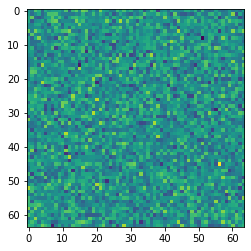

In [16]:
taus = np.round(np.arange(-0.01,0.28,0.03),2)
spiketimes = np.array(imec0_units['times'][chosen])
data = matrix_green_data
datatimes = matrix_color_times
srf_list = []

for k,tau in tqdm(enumerate(taus)):
    idx_arr = []
    stimspikes = []
    spiketime_adj = spiketimes-tau
    for i in range(spiketimes.shape[0]):
        bool_idx = np.logical_and(spiketime_adj[i] > datatimes[0] , spiketime_adj[i] < datatimes[-1])
        idx_arr.append(bool_idx)
    spike_adj_stim = spiketime_adj[idx_arr]

    frame_index = []
    for j in range(spike_adj_stim.shape[0]):
        stim_frame = np.min(np.where(datatimes>spike_adj_stim[j]))-1
        frame_index.append(stim_frame)    

    srf_frames = data[frame_index]
    srf = srf_frames.mean(axis=(0))
    srf_list.append(srf)
    
output = dict(zip(taus,srf_list))

maxima = []
for i in output:
    maxima.append(np.max(output[i]))
    
max_idx = np.where(maxima==np.amax(maxima))[0][0]

plt.imshow(tuple(output.items())[max_idx][1])

10it [00:00, 49.49it/s]


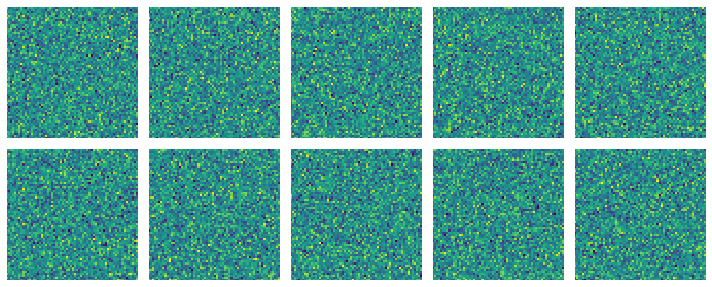

In [17]:
data = output
colormap = 'viridis'
interp = 'none'
nrows = 5
ncols = 2

fig,axs = plt.subplots(ncols, nrows,figsize=(10,10))
axs = axs.ravel()
for i,j in tqdm(enumerate(taus)):
    data2 = output[j]
    out_mean = np.mean(data2)
    out_std = np.std(data2)
    col_min = out_mean-(out_std*3)
    col_max = out_mean+(out_std*3)
    #Generate subplots
    axs[i].imshow(data2, clim=(col_min,col_max),cmap=colormap, 
                  interpolation=interp
                 )
    for ax in fig.get_axes():
        ax.set_frame_on(False);
        ax.set_xticklabels('',visible=False);
        ax.set_xticks([]);
        ax.set_yticklabels('',visible=False);
        ax.set_yticks([])
        ax.set_aspect(1.0)
        ax.set_xlim(0,64)
        ax.set_ylim(0,64)
    plt.tight_layout()

### UV Receptive Field

In [18]:
matrix_uv_data = matrix_data['uv_data']

10it [00:00, 46.29it/s]


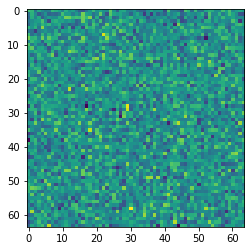

In [19]:
taus = np.round(np.arange(-0.01,0.28,0.03),2)
spiketimes = np.array(imec0_units['times'][chosen])
data = matrix_uv_data
datatimes = matrix_color_times
srf_list = []

for k,tau in tqdm(enumerate(taus)):
    idx_arr = []
    stimspikes = []
    spiketime_adj = spiketimes-tau
    for i in range(spiketimes.shape[0]):
        bool_idx = np.logical_and(spiketime_adj[i] > datatimes[0] , spiketime_adj[i] < datatimes[-1])
        idx_arr.append(bool_idx)
    spike_adj_stim = spiketime_adj[idx_arr]

    frame_index = []
    for j in range(spike_adj_stim.shape[0]):
        stim_frame = np.min(np.where(datatimes>spike_adj_stim[j]))-1
        frame_index.append(stim_frame)    

    srf_frames = data[frame_index]
    srf = srf_frames.mean(axis=(0))
    srf_list.append(srf)
    
output = dict(zip(taus,srf_list))

maxima = []
for i in output:
    maxima.append(np.max(output[i]))
    
max_idx = np.where(maxima==np.amax(maxima))[0][0]

plt.imshow(tuple(output.items())[max_idx][1])

10it [00:00, 49.96it/s]


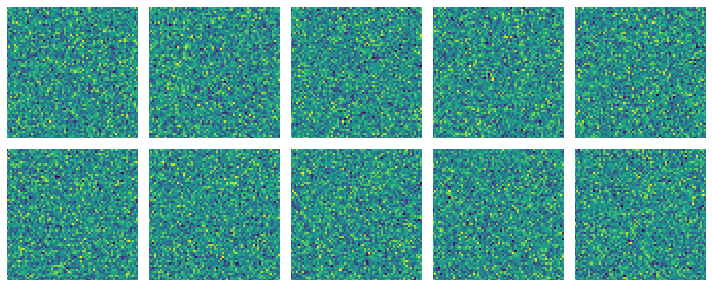

In [20]:
data = output
colormap = 'viridis'
interp = 'none'
nrows = 5
ncols = 2

fig,axs = plt.subplots(ncols, nrows,figsize=(10,10))
axs = axs.ravel()
for i,j in tqdm(enumerate(taus)):
    data2 = output[j]
    out_mean = np.mean(data2)
    out_std = np.std(data2)
    col_min = out_mean-(out_std*3)
    col_max = out_mean+(out_std*3)
    #Generate subplots
    axs[i].imshow(data2, clim=(col_min,col_max),cmap=colormap, 
                  interpolation=interp
                 )
    for ax in fig.get_axes():
        ax.set_frame_on(False);
        ax.set_xticklabels('',visible=False);
        ax.set_xticks([]);
        ax.set_yticklabels('',visible=False);
        ax.set_yticks([])
        ax.set_aspect(1.0)
        ax.set_xlim(0,64)
        ax.set_ylim(0,64)
    plt.tight_layout()


### PSTHs for Common Gratings Features

All gratings stimuli have shared features, despite being presented under different LED conditons including spatial frequency and orientation.

In [21]:
data1 = imec0_units; data = pd.DataFrame(data1.reset_index(drop = True))
stim_data = gratings_data; condition='ori'
unit = 42; times = np.array(data.times[unit])
pre = 1; post=2; binsize=0.05
numbins = int((post+pre) / binsize)
x = np.arange(-pre,post,binsize)
colors = plt.cm.viridis(np.linspace(0,1,11))

In [25]:
def psth_line_overlay(spike_data, unit, stim_data, condition, title='', pre=0.5, post=2.5,binsize=0.05,variance=True):
    times = np.array(spike_data.times[unit])
    numbins = int((post+pre)/binsize)
    conds = np.unique(stim_data[condition])
    num_conds = len(conds)
    x = np.arange(-pre,post,binsize)
    colors = plt.cm.viridis(np.linspace(0,1,num_conds))
    
    psth_all=[]
    fig,ax = plt.subplots()
    
    for i,cond in enumerate(np.unique(stim_data[condition])):
        triggers = np.array(stim_data['times'][stim_data[condition] == cond])
        bytrial = np.zeros((len(triggers),numbins-1))
        for j, trigger in enumerate(triggers):
            trial = triggers[j]
            start = trial-pre
            end = trial+post
            bins_ = np.arange(start,end,binsize)
            trial_spikes = times[np.logical_and(times>=start, times<=end)]
            hist,edges = np.histogram(trial_spikes,bins=bins_)
            if len(hist)==numbins-1:
                bytrial[j]=hist
            elif len(hist)==numbins:
                bytrial[j]=hist[:-1]
        psth = np.mean(bytrial,axis=0)/binsize
        if isinstance(conds[i],float)==True:
            ax.plot(x[:-1],psth, color=colors[i], label=str(round(conds[i],2)))
#         if isinstance(conds[i],tuple)==True:
#             ax.plot(x[:-1],psth, color=colors[i], label=str(round(conds[i],2)))
        else:
            ax.plot(x[:-1],psth, color=colors[i], label=str(conds[i]))
        if variance == True:
            var = np.std(bytrial,axis=0)/binsize/np.sqrt((len(triggers)))
            upper = psth+var
            lower = psth-var
            ax.fill_between(x[:-1],upper,psth,alpha=0.1,color=colors[i])
            ax.fill_between(x[:-1],lower,psth,alpha=0.1,color=colors[i])
    ax.axvline(0,linestyle='dashed')
    plt.legend(loc=(1.05,0.48))
    plt.title(title)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.draw()
    return(fig)

In [26]:
def psth_bars(spike_data,unit,stim_data,condition,title='',pre=0.5,post=2.5,binsize=0.05):
    times = np.array(spike_data.times[unit])
    numbins = int((post+pre)/binsize)
    num_conds = len(np.unique(stim_data[condition]))
    
    psth_all=[]
    fig,ax = plt.subplots(num_conds,1)
    
    for i,cond in enumerate(np.unique(stim_data[condition])):
        triggers = np.array(stim_data['times'][stim_data[condition] == cond])
        bytrial = np.zeros((len(triggers),numbins-1))
        for j, trigger in enumerate(triggers):
            trial = triggers[j]
            start = trial-pre
            end = trial+post
            bins_ = np.arange(start,end,binsize)
            trial_spikes = times[np.logical_and(times>=start, times<=end)]
            hist,edges = np.histogram(trial_spikes,bins=bins_)
            if len(hist)==numbins-1:
                bytrial[j]=hist
            elif len(hist)==numbins:
                bytrial[j]=hist[:-1]
        psth = np.mean(bytrial,axis=0)/binsize
        psth = np.reshape(psth,(1,len(psth)))
        psth_all.append(psth)
        im = ax[i].imshow(psth,aspect=3, vmin=0,vmax=np.max(psth_all),interpolation='gaussian')
        if isinstance(cond,float)==True:
            ax[i].set_ylabel(str(round(cond,2)),rotation=0,labelpad=20,fontsize=12,va='center')
        #elif isinstance(cond,tuple)==True:
            ax[i].set_ylabel(str(cond),rotation=0,labelpad=32,fontsize=10,va='center')
        else:
            ax[i].set_ylabel(str(cond),rotation=0,labelpad=20,fontsize=12,va='center')
        ax[i].set_yticks([])
        ax[i].axvline(pre/binsize,color='r',linewidth=3)
        ax[i].set_xticks([])

    fig.subplots_adjust(hspace=0,wspace=0)
    cbar_ax = fig.add_axes([0.93, 0.15, 0.03, 0.7])
    fig.suptitle(title, fontsize=15)
    fig.colorbar(im,cax=cbar_ax)
    cbar_ax.set_title('Hz')
    plt.show()
    return(fig)

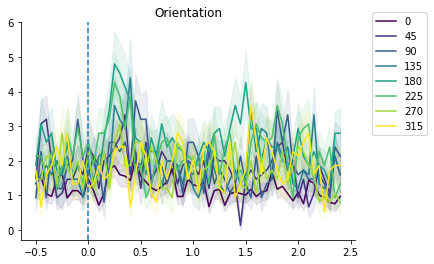

In [174]:
a = psth_line_overlay(spike_data = imec0_units, unit = chosen, stim_data = gratings_data, condition='ori',
         title = 'Orientation')

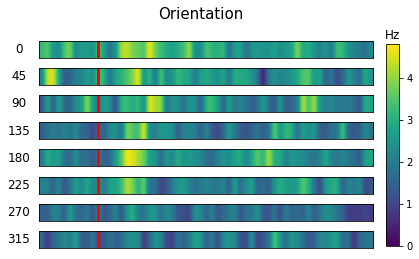

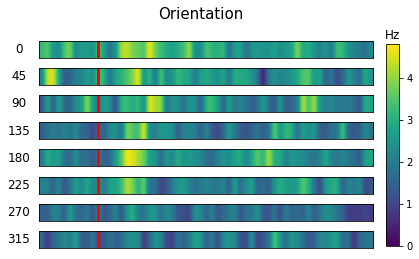

In [26]:
psth_bars(spike_data = imec0_units, unit = chosen, stim_data = gratings_data, condition='ori',
         title = 'Orientation')

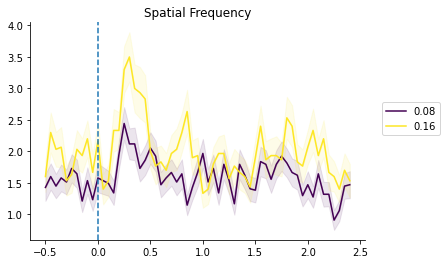

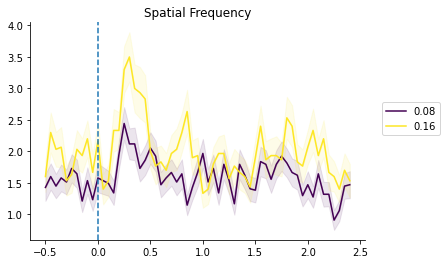

In [27]:
psth_line_overlay(spike_data = imec0_units, unit = chosen, stim_data = gratings_data, condition='SF',
         title = 'Spatial Frequency')

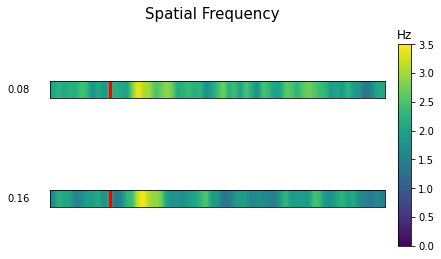

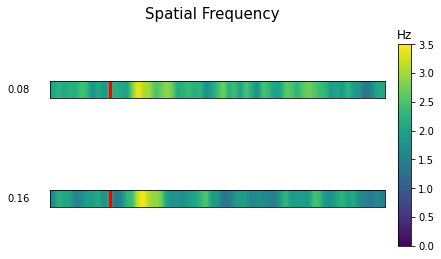

In [28]:
psth_bars(spike_data = imec0_units, unit = chosen, stim_data = gratings_data, condition='SF',
         title = 'Spatial Frequency')

### Gratings Orientation PSTHs

In [29]:
gratings_orientation = gratings_data[gratings_data['condition']=='orientation']
gratings_orientation.head()

index    condition  frame_no  TF    SF  ori  green  uv      times
0      0  orientation         9   2  0.16   45    NaN NaN  776.91641
1      1  orientation        14   2  0.16  270    NaN NaN  779.91650
2      2  orientation         8   2  0.16    0    NaN NaN  782.91634
3      3  orientation         6   2  0.08  270    NaN NaN  785.91401
4      4  orientation        10   2  0.16   90    NaN NaN  788.91584

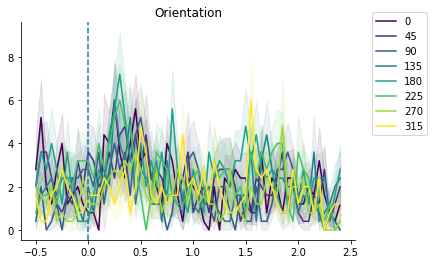

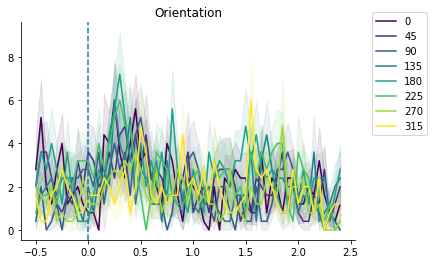

In [30]:
psth_line_overlay(spike_data = imec0_units, unit = chosen, stim_data = gratings_orientation, condition='ori',
         title = 'Orientation')

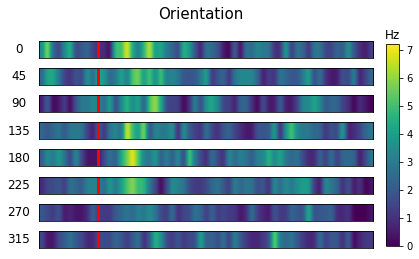

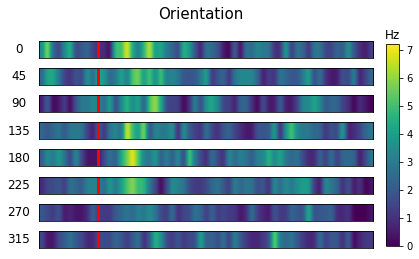

In [31]:
psth_bars(spike_data = imec0_units, unit = chosen, stim_data = gratings_orientation, condition='ori',
         title = 'Orientation')

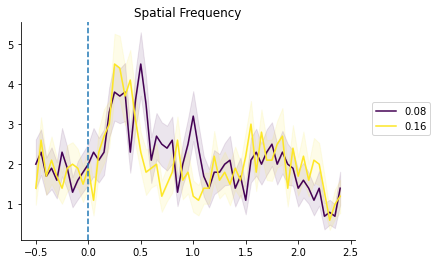

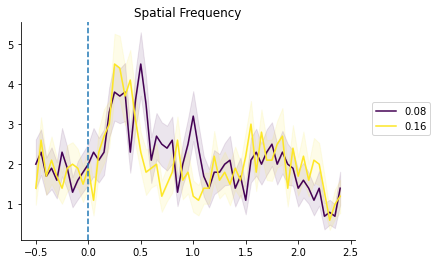

In [32]:
psth_line_overlay(spike_data = imec0_units, unit = chosen, stim_data = gratings_orientation, condition='SF',
         title = 'Spatial Frequency')

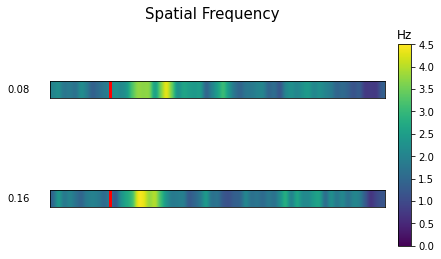

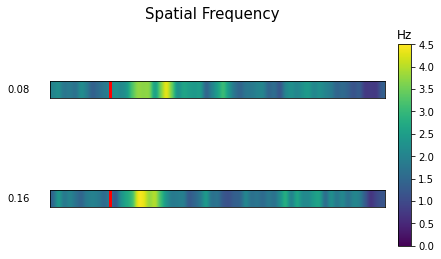

In [33]:
psth_bars(spike_data = imec0_units, unit = chosen, stim_data = gratings_orientation, condition='SF',
         title = 'Spatial Frequency')

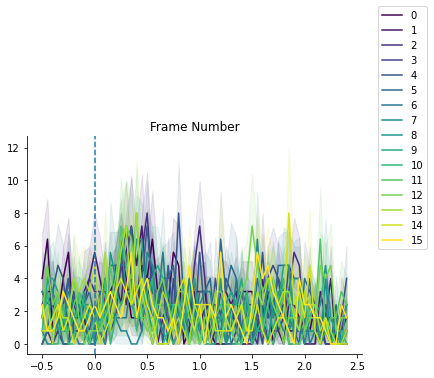

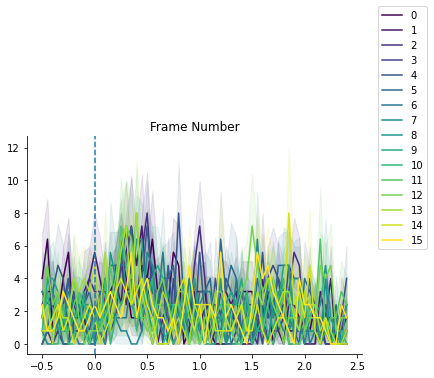

In [34]:
psth_line_overlay(spike_data = imec0_units, unit = chosen, stim_data = gratings_orientation, condition='frame_no',
         title = 'Frame Number')

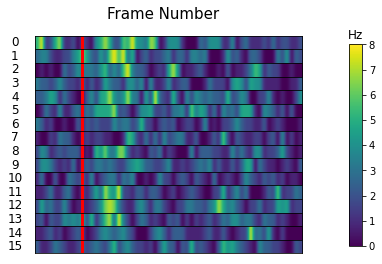

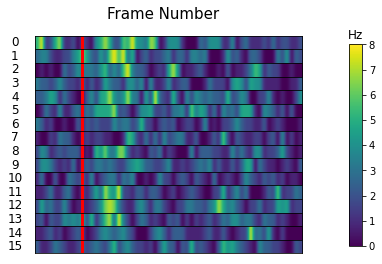

In [35]:
psth_bars(spike_data = imec0_units, unit = chosen, stim_data = gratings_orientation, condition='frame_no',
         title = 'Frame Number')

### Gratings Color

In [36]:
gratings_color = gratings_data[gratings_data['condition']=='color']
#gratings_color = gratings_color.sort_values(['green','uv']).reset_index()
gratings_color = gratings_color.drop(columns=['index']).reset_index()
gratings_color.head()

index condition  frame_no  TF    SF  ori  green    uv       times
0    400     color         1   2  0.08    0  -0.92  0.73  1988.00044
1    401     color        12   2  0.08    0   1.00 -0.84  1991.00073
2    402     color         2   2  0.08    0  -0.70  0.43  1994.00042
3    403     color         8   2  0.08    0   0.40 -0.39  1996.99973
4    404     color         1   2  0.08    0  -0.92  0.73  1999.99981

In [37]:
color_condition = []
for i in range(gratings_color.shape[0]):
    b = round(gratings_color['uv'][i],2)
    g = round(gratings_color['green'][i],2)
    condition = tuple([g, b])
    color_condition.append(condition)
    
gratings_color['color']=color_condition
gratings_color.head()

index condition  frame_no  TF    SF  ori  green    uv       times  \
0    400     color         1   2  0.08    0  -0.92  0.73  1988.00044   
1    401     color        12   2  0.08    0   1.00 -0.84  1991.00073   
2    402     color         2   2  0.08    0  -0.70  0.43  1994.00042   
3    403     color         8   2  0.08    0   0.40 -0.39  1996.99973   
4    404     color         1   2  0.08    0  -0.92  0.73  1999.99981   

           color  
0  (-0.92, 0.73)  
1   (1.0, -0.84)  
2   (-0.7, 0.43)  
3   (0.4, -0.39)  
4  (-0.92, 0.73)

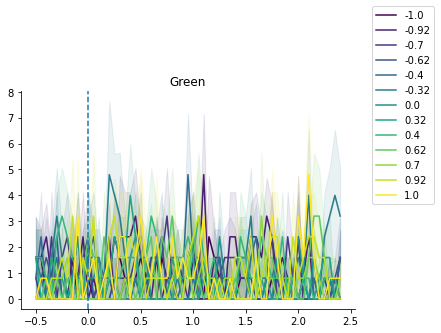

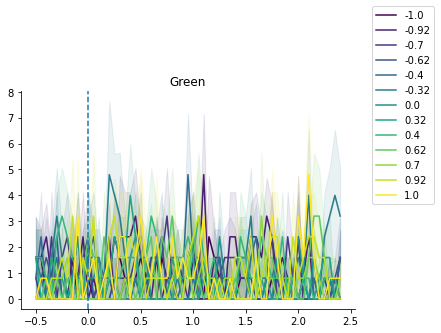

In [38]:
psth_line_overlay(spike_data = imec0_units, unit = chosen, stim_data = gratings_color, condition='green',
         title = 'Green')

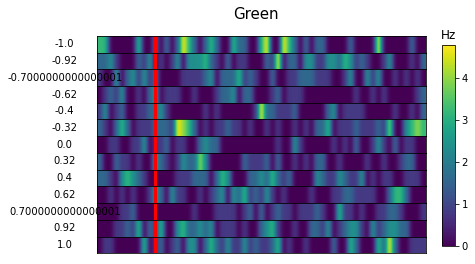

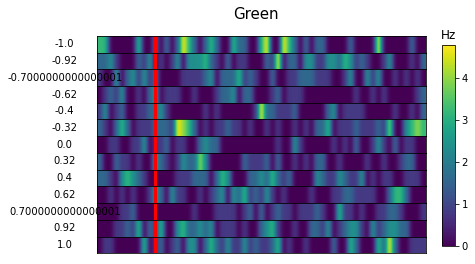

In [39]:
psth_bars(spike_data = imec0_units, unit = chosen, stim_data = gratings_color, condition='green',
         title = 'Green')

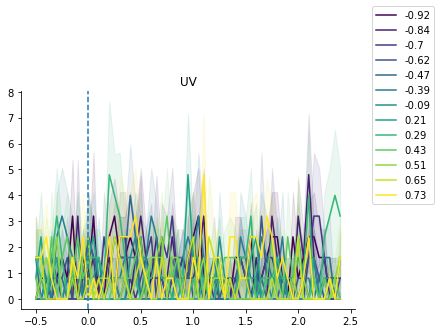

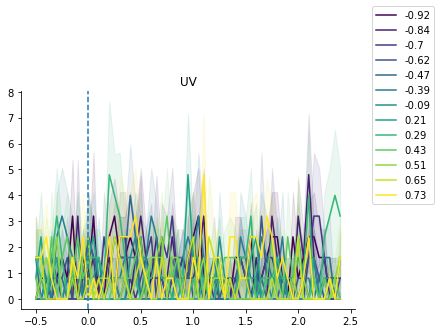

In [40]:
psth_line_overlay(spike_data = imec0_units, unit = chosen, stim_data = gratings_color, condition='uv',
         title = 'UV')

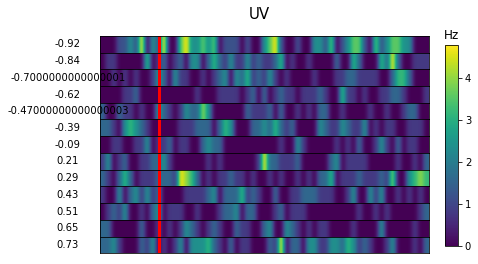

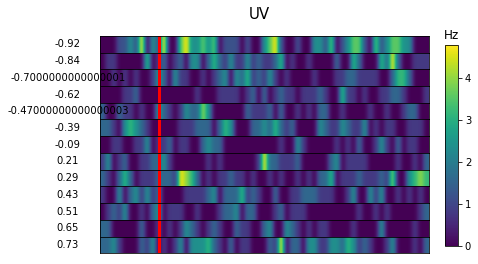

In [41]:
psth_bars(spike_data = imec0_units, unit = chosen, stim_data = gratings_color, condition='uv',
         title = 'UV')

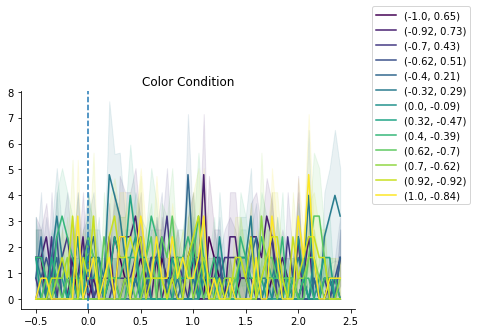

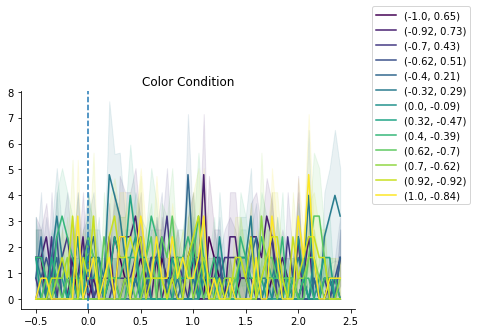

In [42]:
psth_line_overlay(spike_data = imec0_units, unit = chosen, stim_data = gratings_color, condition='color',
         title = 'Color Condition')

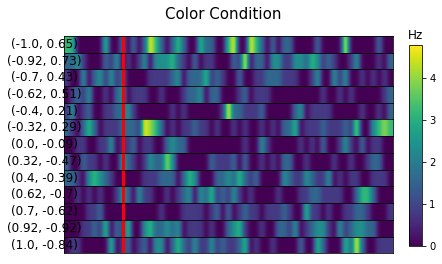

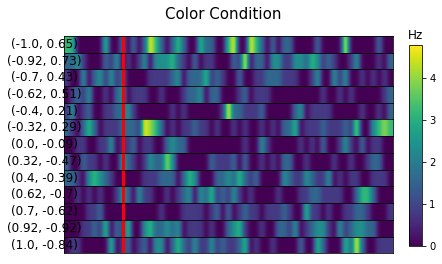

In [43]:
psth_bars(spike_data = imec0_units, unit = chosen, stim_data = gratings_color, condition='color',
         title = 'Color Condition')

### Gratings Green

In [44]:
gratings_green = gratings_data[gratings_data['condition']=='green']
gratings_green.head()

index condition  frame_no  TF    SF  ori  green  uv       times
725      0     green         5   2  0.08  225    NaN NaN  2989.22833
726      1     green         4   2  0.08  180    NaN NaN  2992.22891
727      2     green        15   2  0.16  315    NaN NaN  2995.22820
728      3     green        10   2  0.16   90    NaN NaN  2998.22794
729      4     green         8   2  0.16    0    NaN NaN  3001.22782

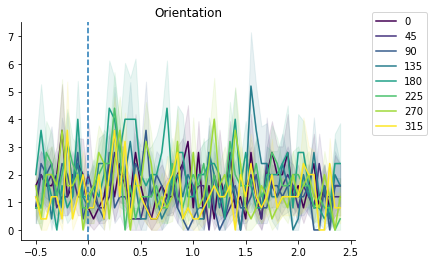

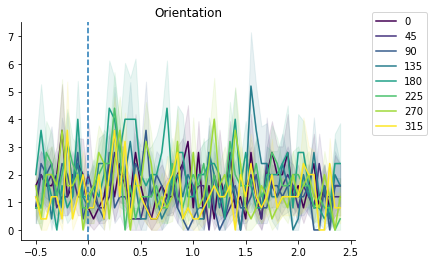

In [45]:
psth_line_overlay(spike_data = imec0_units, unit = chosen, stim_data = gratings_green, condition='ori',
         title = 'Orientation')

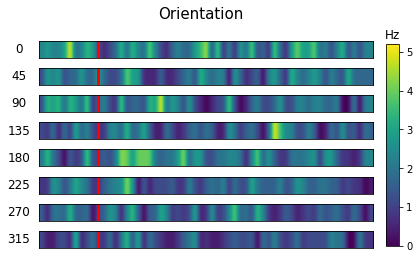

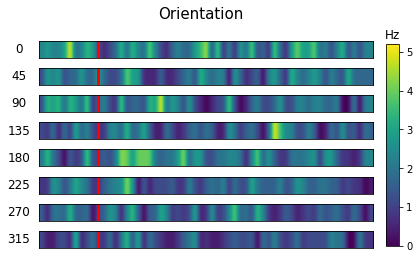

In [46]:
psth_bars(spike_data = imec0_units, unit = chosen, stim_data = gratings_green, condition='ori',
         title = 'Orientation')

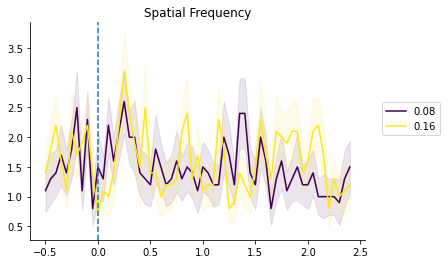

In [156]:
a = psth_line_overlay(spike_data = imec0_units, unit = chosen, stim_data = gratings_green, condition='SF',
         title = 'Spatial Frequency')
a.savefig(r'C:\Users\juans\Documents\testfig\plot.jpg')

IndexError: GridSpec slice would result in no space allocated for subplot

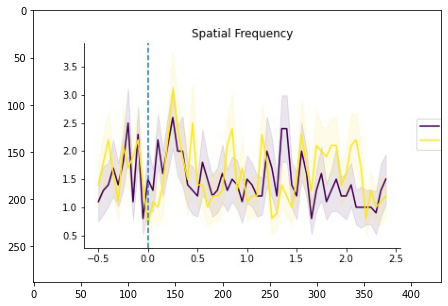

In [116]:
fig = plt.figure(figsize=(20,5))
gs = GridSpec(4,4)

ax1 = fig.add_subplot(gs[:15,:2])
plt.imshow(plt.imread(r"C:\Users\juans\Documents\testfig\plot.jpg"))
ax2 = fig.add_subplot(gs[15:20,2:5])


In [ ]:
### fig = plt.figure()
gs = GridSpec(4,4)

x1 = fig.add_subplot(gs[:2,:1])
x1.append(a)

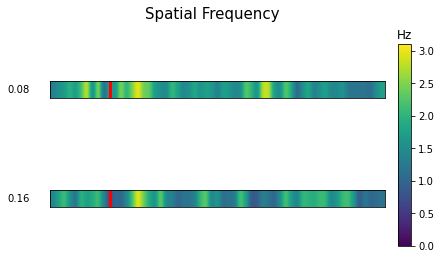

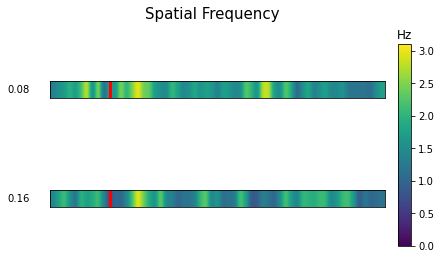

In [48]:
psth_bars(spike_data = imec0_units, unit = chosen, stim_data = gratings_green, condition='SF',
         title = 'Spatial Frequency')

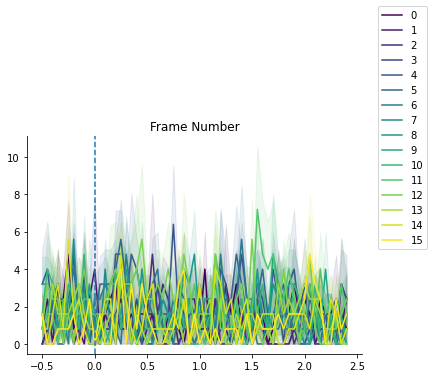

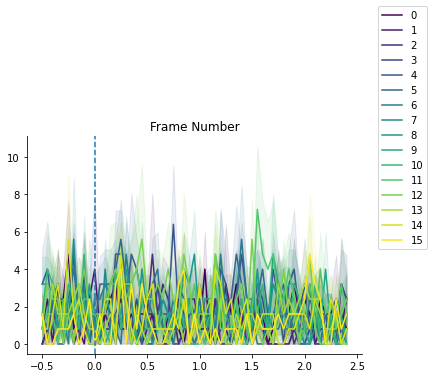

In [49]:
psth_line_overlay(spike_data = imec0_units, unit = chosen, stim_data = gratings_green, condition='frame_no',
         title = 'Frame Number')

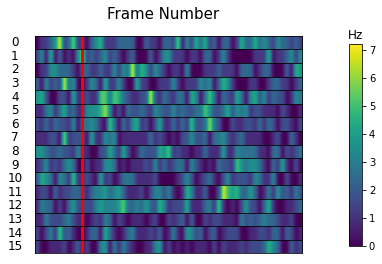

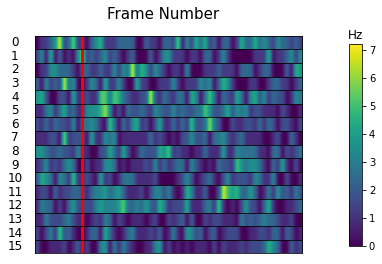

In [50]:
psth_bars(spike_data = imec0_units, unit = chosen, stim_data = gratings_green, condition='frame_no',
         title = 'Frame Number')

### Gratings UV

In [51]:
gratings_uv = gratings_data[gratings_data['condition']=='uv']
gratings_uv.head()

index condition  frame_no  TF    SF  ori  green  uv       times
1125      0        uv         5   2  0.08  225    NaN NaN  4244.80971
1126      1        uv         1   2  0.08   45    NaN NaN  4247.81000
1127      2        uv         0   2  0.08    0    NaN NaN  4250.80930
1128      3        uv         5   2  0.08  225    NaN NaN  4253.80894
1129      4        uv         3   2  0.08  135    NaN NaN  4256.80880

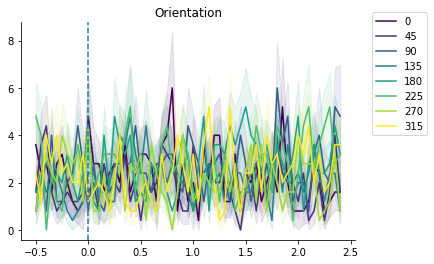

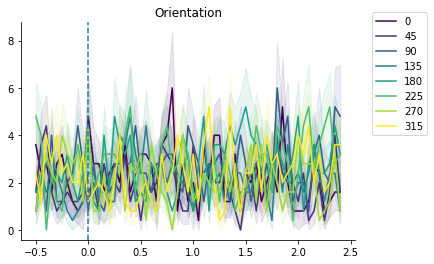

In [52]:
psth_line_overlay(spike_data = imec0_units, unit = chosen, stim_data = gratings_uv, condition='ori',
         title = 'Orientation')

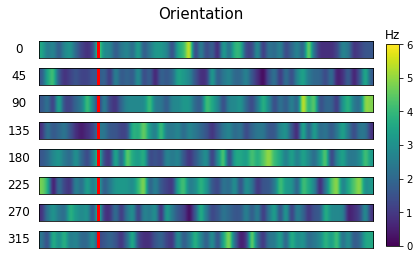

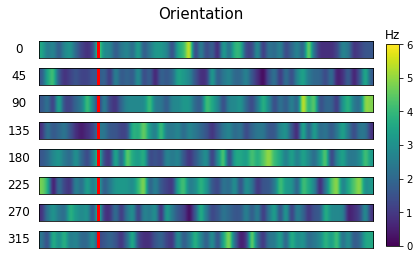

In [53]:
psth_bars(spike_data = imec0_units, unit = chosen, stim_data = gratings_uv, condition='ori',
         title = 'Orientation')

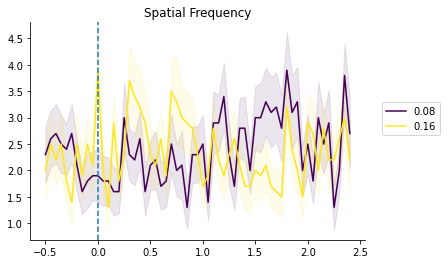

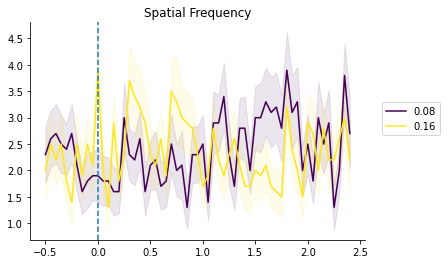

In [54]:
psth_line_overlay(spike_data = imec0_units, unit = chosen, stim_data = gratings_uv, condition='SF',
         title = 'Spatial Frequency')

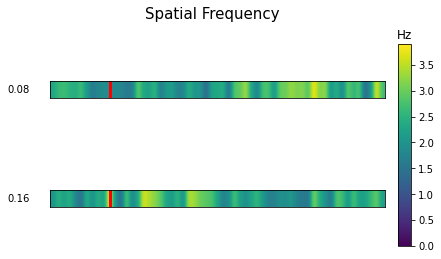

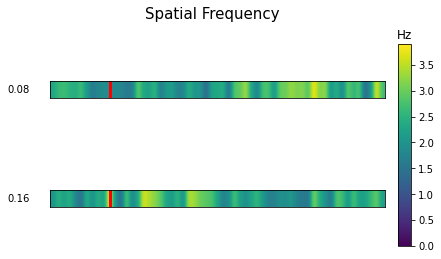

In [55]:
psth_bars(spike_data = imec0_units, unit = chosen, stim_data = gratings_uv, condition='SF',
         title = 'Spatial Frequency')

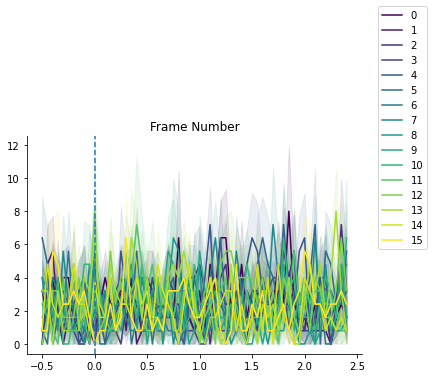

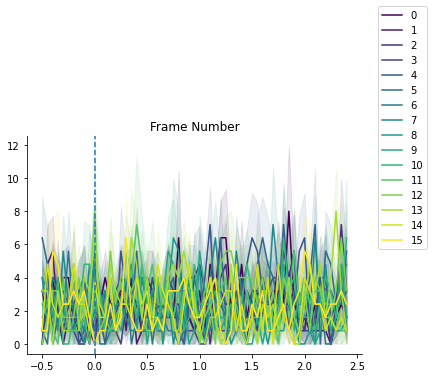

In [56]:
psth_line_overlay(spike_data = imec0_units, unit = chosen, stim_data = gratings_uv, condition='frame_no',
         title = 'Frame Number')

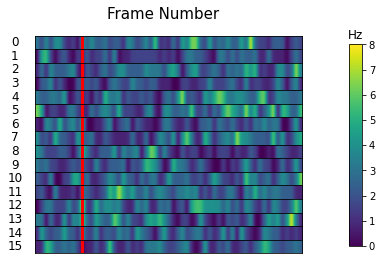

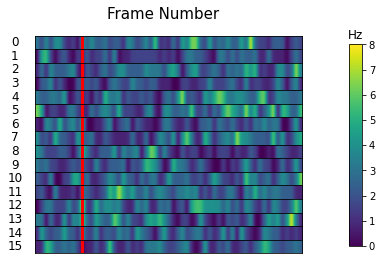

In [57]:
psth_bars(spike_data = imec0_units, unit = chosen, stim_data = gratings_uv, condition='frame_no',
         title = 'Frame Number')

In [30]:
def single_cell_summary(path,probe,spike_data,unit,matrix_data,matrix_times,gratings_data,
                        gratings_conditions = ['orientation','color','green','uv'],
                        psth = 'lines',colors='viridis',savepath=path):
    
    raw_data = glob(path+'*'+str(probe)+'\*ap.bin')[0]
    imec_meta = readMeta(glob(path+'*'+str(probe))[0])
    sampRate = float(imec_meta['imSampRate']) #get sampling rate (Hz)
    if os.path.isdir(os.path.join(path,'Figures'))==False:
        os.mkdir(os.path.join(path,'Figures'))
    probe_folder = os.mkdir(os.path.join(path,'Figures',probe))
    image_folder = os.mkdir(os.path.join(path,'Figures',probe,'unit'+str(unit)))
    image_path = os.path.join(path,'Figures',probe,'unit'+str(unit))
    
    #Separate units by probe
    units_df = spike_data.loc[spike_data['probe']==probe]
    
    #generate waveform figure
    mean_wf = sq.mean_waveform(rawdata=raw_data,times=units_df.times[unit],channels=385,sampling_rate=float(sampRate))
    for i in mean_wf:
        plt.plot(i)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.xticks([])
        plt.savefig(os.path.join(image_path,'unit'+str(unit)+'_waveform.svg'))
        
    #generate receptive field grid figures
    lum_rfs = rf_array(units_df, unit, matrix_data[0], matrix_times[0])
    green_rfs = rf_array(units_df, unit, matrix_data[1], matrix_times[1])
    uv_rfs = rf_array(units_df, unit, matrix_data[2], matrix_times[2])
    
    rf_outputs = [lum_rfs,green_rfs, uv_rfs]
    
    for j in rf_outputs:
        rf_grid(j,ncols=4)
        rf_grid.savefig(os.path.join(image_path,'unit'+str(unit)+str(j)+'grid.svg'))
        

    for k in gratings_conditions:
        gratings_df = gratings_data[gratings_data==k]
        gratings_df = gratings_df.drop(columns=['index']).reset_index()
        
        if k == 'color' or 'Color':
            #
            color_condition = []
            for x in range(gratings_color.shape[0]):
                b = round(gratings_color['uv'][x],2)
                g = round(gratings_color['green'][x],2)
                condition = tuple([g, b])
                color_condition.append(condition)

            gratings_color['color']=color_condition
            gratings_color.head()
            
            
            if psth == 'lines':
            #Generate PSTH for evoked response to green, uv, and combined color condition   
                psth_color = psth_line_overlay(spike_data=units_df, unit=unit, stim_data=gratings_color,condition='color',
                                  title = 'Color Condition')
                psth_color.savefig(os.path.join(image_path,'unit'+str(unit)+'_psthColor.svg'))
                
                psth_green = psth_line_overlay(spike_data=units_df,unit=unit,stim_data=gratings_color,condition='green',
                                  title = 'Green')
                psth_green.savefig(os.path.join(image_path,'unit'+str(unit)+'_psthGreen.svg'))
                
                psth_uv = psth_line_overlay(spike_data=units_df,unit=unit,stim_data=gratings_color,condition='uv',
                                  title = 'UV')
                psth_uv.savefig(os.path.join(image_path,'unit'+str(unit)+'_psthUV.svg'))
                
            if psth == 'heatmap':
                psth_color = psth_bars(spike_data=units_df, unit=unit,stim_data = gratings_color,condition='color',
                          title = 'Color Condition')
                psth_color.savefig(os.path.join(image_path,'unit'+str(unit)+'_psthColor.svg'))
                
                psth_green = psth_bars(spike_data=units_df, unit=unit,stim_data = gratings_color,condition='green',
                          title = 'Green')
                psth_green.savefig(os.path.join(image_path,'unit'+str(unit)+'_psthGreen.svg'))
                
                psth_uv = psth_bars(spike_data=units_df, unit=unit,stim_data = gratings_color,condition='uv',
                          title = 'UV')
                psth_uv.savefig(os.path.join(image_path,'unit'+str(unit)+'_psthUV.svg'))
                
        else:
            if psth == 'lines':
                psth_ori = psth_line_overlay(spike_data = units_df, unit = unit, stim_data = gratings_df, condition='ori',
                                  title = 'Orientation')
                psth_ori.savefig(os.path.join(image_path,'unit'+str(unit)+'_psthOri'+k+'.svg'))
                
                psth_sf = psth_line_overlay(spike_data = units_df, unit = unit, stim_data = gratings_df, condition='SF',
                                  title = 'Spatial Frequency')
                psth_sf.savefig(os.path.join(image_path,'unit'+str(unit)+'_psthSF'+k+'.svg'))
                
            if psth == 'heatmap':
                psth_ori = psth_bars(spike_data = units_df, unit = unit, stim_data = gratings_df, condition='ori',
                                  title = 'Orientation')
                psth_ori.savefig(os.path.join(image_path,'unit'+str(unit)+'_psthOri'+k+'.svg'))
                
                psth_sf = psth_bars(spike_data = units_df, unit = unit, stim_data = gratings_df, condition='SF',
                                  title = 'Spatial Frequency')
                psth_sf.savefig(os.path.join(image_path,'unit'+str(unit)+'_psthSF'+k+'.svg'))


In [15]:
mtx_data = [matrix_data['luminance_data'],matrix_data['green_data'],matrix_data['uv_data']]
mtx_times = [matrix_data['luminance_times'],matrix_data['color_times'],matrix_data['color_times']]

0it [00:00, ?it/s]


NameError: name 'datatimes' is not defined

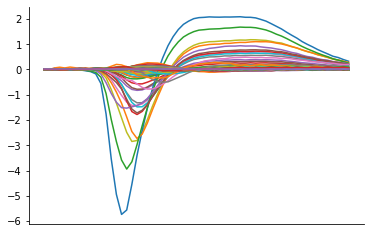

In [31]:
single_cell_summary(path=path,probe='imec0',spike_data=imec0_units,unit=42,matrix_data=mtx_data,matrix_times=mtx_times,gratings_data=gratings_data,
                        gratings_conditions = ['orientation','color','green','uv'],
                        psth = 'lines',colors='viridis')